# A notebook to compute the quantum Lorentz force operator

### Simulation parameters and environment variables

In [7]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 2         		
mu = g2mu / g**2

ns = 50      


nevents = 1

In [8]:

import os

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
# os.environ["CUDA_VISIBLE_DEVICES"]="4"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
import curraun.qhat as qhat

import pickle
from tqdm import tqdm

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define the simulation routine

In [3]:
def simulate_Lorentz(ev): 
    
    # Create a dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_tforce = qhat.TransportedForce(s, E0)
    
    # Create the objects to store the results
    up = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    fy = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    fz = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    fy2 = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    fz2 = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                
                # Compute the integrated Lorentz force
                qhat_tforce.compute()
                
                # Copy results to the CPU
                if use_cuda:
                    qhat_tforce.copy_to_host()
                
                fi = qhat_tforce.fi.copy()
                fi2 = qhat_tforce.fi2.copy()
                up_sim = qhat_tforce.up.copy()
                
                # Copy the desired components of the integrated Lorentz force
                for yz in range(N*N):
                    up[t//DTS, yz] = up_sim[0, :]
                    
                    fy[t//DTS, yz] = fi[0, 1, :]
                    fz[t//DTS, yz] = fi[0, 2, :]
                    
                    fy2[t//DTS, yz] = fi2[0, 1, :]
                    fz2[t//DTS, yz] = fi2[0, 2, :]

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    # Store the results
    output['up'] = up
    
    output['fy'] = fy
    output['fz'] = fz
    
    output['fy2'] = fy2
    output['fz2'] = fz2

    return output

### Run the simulation

In [4]:
import warnings
warnings.filterwarnings('ignore')

for ev in range(nevents):
    output = simulate_Lorentz(ev)
    
    # # Save the files
    # save_dir = os.path.join('..', 'simulations', 'LorentzSquared')
    # os.makedirs(save_dir, exist_ok=True)

    # np.save(os.path.join(save_dir, 'up_%i.npy' % ev), output['up'])
    
    # # np.save(os.path.join(save_dir, 'Ay_%i.npy' % ev), output['fy'])
    # # np.save(os.path.join(save_dir, 'Az_%i.npy' % ev), output['fz'])
    
    # np.save(os.path.join(save_dir, 'Ay2_%i.npy' % ev), output['fy2'])
    # np.save(os.path.join(save_dir, 'Az2_%i.npy' % ev), output['fz2'])



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Event 1: 100%|██████████| 256/256 [00:10<00:00, 25.16it/s]


### Debug

In [5]:
up = output['up'][:, 0, :]

fy = output['fy'][:, 0, :]
fz = output['fz'][:, 0, :]

fy2 = output['fy2'][:, 0, :]
fz2 = output['fz2'][:, 0, :]

In [6]:
print(up[10])

print(fy[10])
print(fz[10])

print(fy2[10])
print(fz2[10])

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
[ 0.        -0.00636639j -0.00247679+0.00013119j -0.002561  +0.00519651j
  0.00247679+0.00013119j  0.        +0.00747493j -0.00149944+0.00793189j
  0.002561  +0.00519651j  0.00149944+0.00793189j  0.        -0.00110854j]
[ 0.        +0.00805992j -0.00430314+0.00366315j -0.00290559-0.00255611j
  0.00430314+0.00366315j  0.        -0.01786005j -0.00879988-0.00326505j
  0.00290559-0.00255611j  0.00879988-0.00326505j  0.        +0.00980012j]
[ 0.05119258-0.00000000e+00j  0.02883778+9.73987553e-03j
 -0.02648574+4.45949914e-04j  0.02883778-9.73987553e-03j
  0.08114091-0.00000000e+00j  0.03669651-1.90664986e-03j
 -0.02648574-4.45949914e-04j  0.03669651+1.90664986e-03j
  0.06376624-4.62419146e-20j]
[ 0.07137049-5.40367060e-19j -0.00126613-1.86057265e-02j
 -0.06091165+4.47072298e-02j -0.00126613+1.86057265e-02j
  0.28007117-0.00000000e+00j  0.01879142-3.14405130e-02j
 -0.06091165-4.47072298e-02j  0.01879142+3.14405130e-02j
  0.12702

In [17]:
fy2_test = su.GROUP_TYPE([su.mul(fy[t], fy[t]) for t in range(len(fy))])
fz2_test = su.GROUP_TYPE([su.mul(fz[t], fz[t]) for t in range(len(fz))])

In [18]:
fy2_tr = [su.tr(fy2[t]) for t in range(len(fy2))]
fz2_tr = [su.tr(fz2[t]) for t in range(len(fz2))]

fy2_tr_test = [-E0**2 * su.tr(fy2_test[t]) for t in range(len(fy2_test))]
fz2_tr_test = [-E0**2 * su.tr(fz2_test[t]) for t in range(len(fz2_test))]

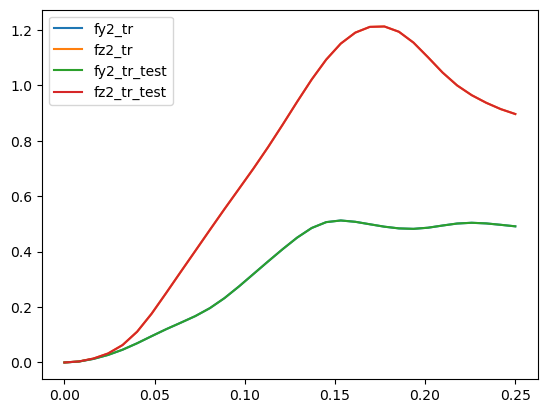

In [ ]:
import matplotlib.pyplot as plt

xp = np.linspace(0, tau_sim, nplus)

plt.plot(xp, fy2_tr)
plt.plot(xp, fz2_tr)
plt.plot(xp, fy2_tr_test)
plt.plot(xp, fz2_tr_test)

plt.legend(['fy2_tr', 'fz2_tr', 'fy2_tr_test', 'fz2_tr_test'])

### Another debug

In [1]:
import numpy as np

nevents = 100

data_Ay = np.array([np.load(f"../simulations/LorentzSquared/Ay2_{i}.npy") for i in range(nevents)])
data_Az = np.array([np.load(f"../simulations/LorentzSquared/Az2_{i}.npy") for i in range(nevents)])

print(np.shape(data_Ay))
print(np.shape(data_Az))

(100, 32, 16384, 9)
(100, 32, 16384, 9)


In [2]:
# Get the central value

data_usefull_Ay = data_Ay[:, :, 0, :]
data_usefull_Az = data_Az[:, :, 0, :]


In [3]:
# Average over configurations

Ay2_av = np.average(data_usefull_Ay, axis=0)
Az2_av = np.average(data_usefull_Az, axis=0)


In [14]:
# Take the trace

xplus = np.linspace(0, tau_sim, nplus)

py2 = [su.tr(Ay2_av[t]) for t in range(len(Ay2_av))]
pz2 = [su.tr(Az2_av[t]) for t in range(len(Az2_av))]

In [18]:
# Import the classical results

xp = np.loadtxt('/home2/carlos.lamas/curraun/Jets in Glasma Results/ClassicalResults/classical_pi.txt')[0]

piy = np.loadtxt('/home2/carlos.lamas/curraun/Jets in Glasma Results/ClassicalResults/classical_pi.txt')[1]
piz = np.loadtxt('/home2/carlos.lamas/curraun/Jets in Glasma Results/ClassicalResults/classical_pi.txt')[2]

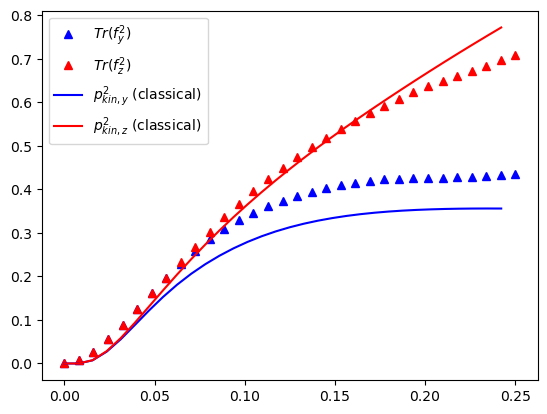

In [22]:
# Plot the results

import matplotlib.pyplot as plt

plt.plot(xplus, py2, 'b^', label=r'$Tr(f_y^2)$')
plt.plot(xplus, pz2, 'r^', label=r'$Tr(f_z^2)$')

plt.plot(xp, piy, 'b-', label=r'$p_{kin, y}^2$ (classical)')
plt.plot(xp, piz, 'r-', label=r'$p_{kin, z}^2$ (classical)')

plt.legend()

plt.savefig('DebugLorentz.png', dpi=300)